In [40]:
import tensorflow as tf
from pathlib import Path
from IPython.display import Image
import numpy as np

import utils
from model.full_unet import FullUnet

import sys
working_directory = str(Path.home() / 'projects/cs230_project_keras/skin_lesion')
sys.path.append(working_directory)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### input shape

Important notice: if we don't include FC head (3 FC layers on top) we may use any input shape, not necessarily `(224, 224, 3)` so we may use `(256, 256, 3)` to compare with pure unet model:

> input_shape: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with 'channels_last' data format) or (3, 224, 224) (with 'channels_first' data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.

## `VGG-16`

Let's start from refreshing of `VGG-16`. Here's a table from the original paper. We may see that it has typical architecture when the size of an image gets smaller and the number of filters is doubling.

### architecture from the paper

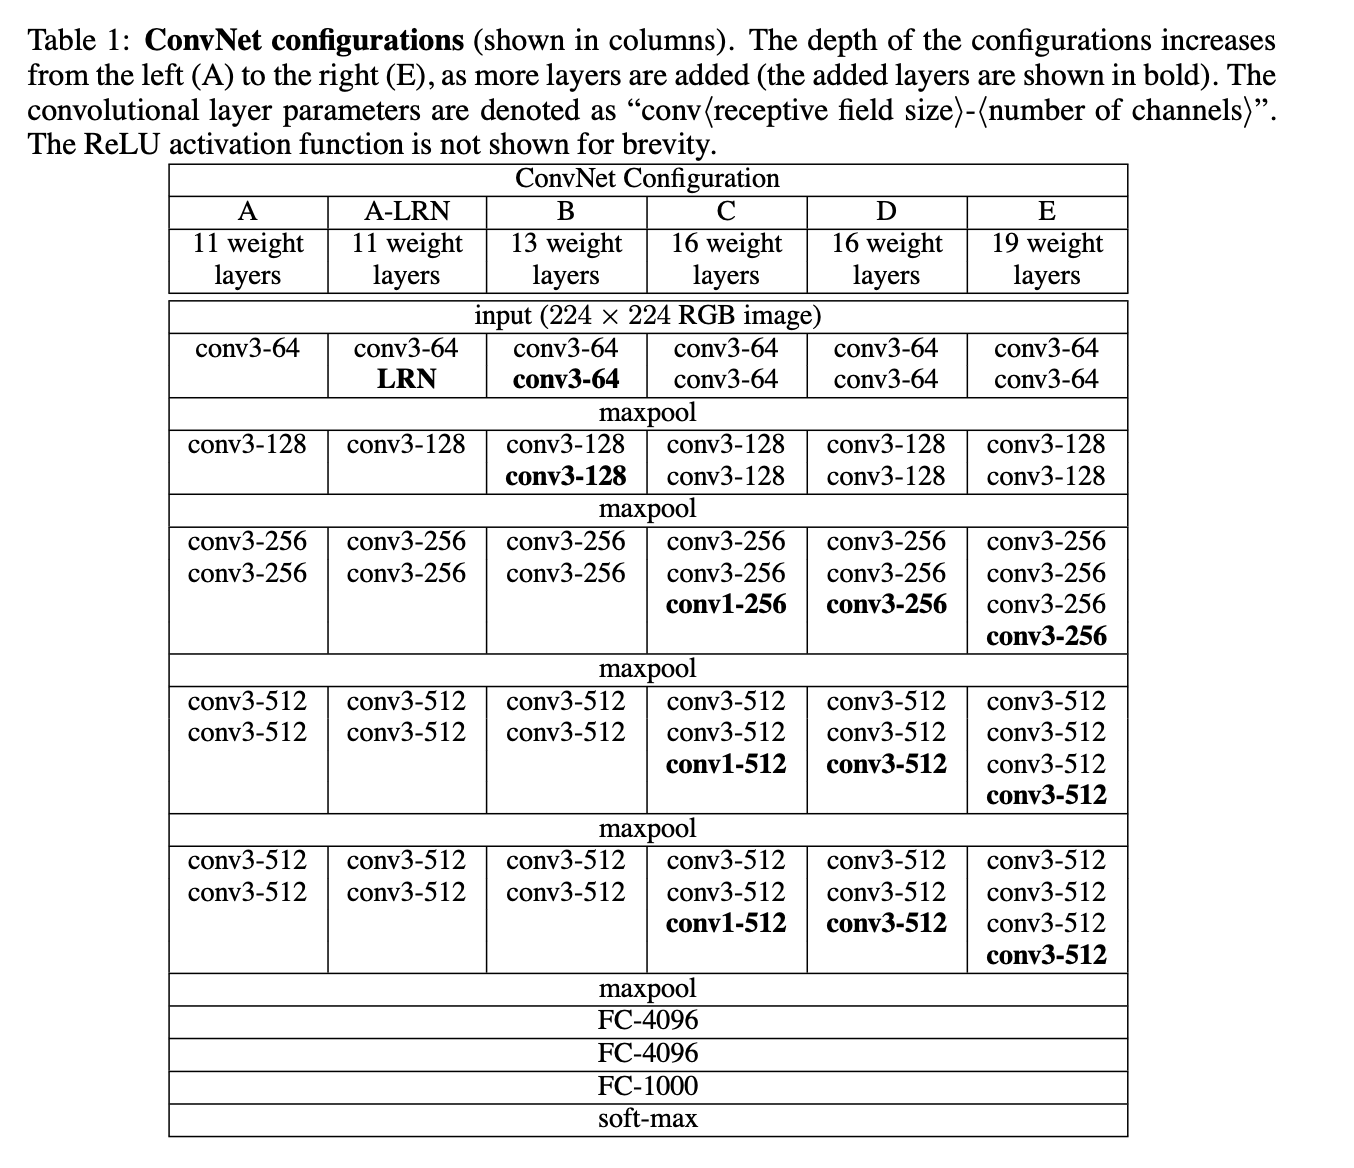

In [10]:
Image("../_misc/vgg.png", width=600, height=900)

### model summary

In [22]:
data_dir  = Path('../experiments/transf_learn_vgg_toy')

In [23]:
params = utils.Params(data_dir / 'params.json')

In [24]:
params.input_shape

[256, 256, 3]

In [25]:
base_model = tf.keras.applications.VGG16(weights='imagenet', 
                                         include_top=False,
                                         input_shape=params.input_shape)

In [26]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

### model output

In [101]:
bs = 2

In [102]:
np.random.seed(params.seed)
x_in = np.random.rand(bs, *params.input_shape)

In [103]:
x_in.shape

(2, 256, 256, 3)

In [104]:
x_in[0, 0, 0, :]

array([0.37454012, 0.95071431, 0.73199394])

In [105]:
x_in = tf.convert_to_tensor(x, dtype=tf.float32)

In [106]:
type(x_in), x_in.dtype

(tensorflow.python.framework.ops.EagerTensor, tf.float32)

In [107]:
x_out = base_model(tf.identity(x_in))

We may see that the output type is in fact `(None, 8, 8, 512)` as we may see in the summary above.

In [108]:
type(x_out), x_out.dtype, x_out.shape

(tensorflow.python.framework.ops.EagerTensor,
 tf.float32,
 TensorShape([2, 8, 8, 512]))

In [109]:
x_in.shape

TensorShape([2, 256, 256, 3])

In [110]:
x_in[0, 0, 0, :]

<tf.Tensor: id=5398, shape=(3,), dtype=float32, numpy=array([0.37454012, 0.9507143 , 0.7319939 ], dtype=float32)>

## full unet

Let's now have a look at a full unet model. There are a few questions that we're interested in:

- how to concatenate layers;
- how to use upsampling (and why don't we use up-convolution);
- how to use `(1, 1)` convolution in the final layer;

### forward pass

In [151]:
full_unet = FullUnet(params=params, 
                     set_seed=True)

In [152]:
full_unet_model = full_unet.get_model()

In [161]:
full_unet_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 256, 256, 64) 1792        input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 256, 256, 64) 36928       conv2d_133[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_28 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_134[0][0]                 
____________________________________________________________________________________________

In [153]:
x_unet_out = full_unet_model(tf.identity(x_in))

We may see that the shape of output is indeed `(None, 256, 256, 1)` as in the summary above.

In [154]:
x_unet_out.shape

TensorShape([2, 256, 256, 1])

In [155]:
x_unet_out.numpy().shape

(2, 256, 256, 1)

In [156]:
x_unet_out.numpy()[0, 0, 0, :]

array([0.4912835], dtype=float32)

In [149]:
x_in.shape

TensorShape([2, 256, 256, 3])

In [150]:
x_in[0, 0, 0, :]

<tf.Tensor: id=7244, shape=(3,), dtype=float32, numpy=array([0.37454012, 0.9507143 , 0.7319939 ], dtype=float32)>

### layer-by-layer

Let's now try to use layers of the model.

In [179]:
x_in_copy = tf.identity(x_in)

In [180]:
x_in_copy.shape

TensorShape([2, 256, 256, 3])

In [181]:
x_in_copy[0, 0, 0, :]

<tf.Tensor: id=8185, shape=(3,), dtype=float32, numpy=array([0.37454012, 0.9507143 , 0.7319939 ], dtype=float32)>

In [182]:
conv1 = full_unet_model.layers[1](x_in_copy)
conv1 = full_unet_model.layers[2](conv1)
pool1 = full_unet_model.layers[3](conv1)

conv2 = full_unet_model.layers[4](pool1)
conv2 = full_unet_model.layers[5](conv2)
pool2 = full_unet_model.layers[6](conv2)

conv3 = full_unet_model.layers[7](pool2)
conv3 = full_unet_model.layers[8](conv3)
pool3 = full_unet_model.layers[9](conv3)

conv4 = full_unet_model.layers[10](pool3)
conv4 = full_unet_model.layers[11](conv4)
pool4 = full_unet_model.layers[12](conv4)

conv5 = full_unet_model.layers[13](pool4)
conv5 = full_unet_model.layers[14](conv5)

#### upsampling

In [183]:
conv5.shape

TensorShape([2, 16, 16, 1024])

In [184]:
full_unet_model.layers[15]

In [185]:
up6_part = full_unet_model.layers[15](conv5)

In [186]:
up6_part.shape

TensorShape([2, 32, 32, 1024])

So we may see that upscaling doubles size of a tensor as expected. What does it do exactly? Looks like it's kind of inverse operation to max pooling (and much simpler than upconvolution):

> Repeats the rows and columns of the data by size[0] and size[1] respectively.

In [189]:
conv5.numpy()[0, 0, :2, 0]

array([0.        , 0.56727237], dtype=float32)

In [190]:
up6_part.numpy()[0, 0, :4, 0]

array([0.        , 0.        , 0.56727237, 0.56727237], dtype=float32)

So we can see that it in fact just repeats values.

#### concatenation

Let's first check shapes of what we concatenate. We concatenate last dimension and get the monster `(..., 1536)`.

In [198]:
conv4.shape, conv4.numpy()[0, 0, 0, :5]

(TensorShape([2, 32, 32, 512]),
 array([0.        , 0.        , 0.        , 0.04930183, 0.        ],
       dtype=float32))

In [196]:
up6_part.shape, up6_part.numpy()[0, 0, 0, -3:]

(TensorShape([2, 32, 32, 1024]),
 array([0.       , 0.8582723, 0.5981804], dtype=float32))

In [195]:
full_unet_model.layers[16]

In [202]:
up6 = full_unet_model.layers[16]([up6_part, conv4])

In [203]:
up6.shape

TensorShape([2, 32, 32, 1536])

In [206]:
up6.numpy()[0, 0, 0, 1021:1029]

array([0.        , 0.8582723 , 0.5981804 , 0.        , 0.        ,
       0.        , 0.04930183, 0.        ], dtype=float32)

So looks like concatenation works.

#### rest of the forward pass

In [209]:
full_unet_model.layers[17:23]

In [210]:
conv6 = full_unet_model.layers[17](up6)
conv6 = full_unet_model.layers[18](conv6)

up7_part = full_unet_model.layers[19](conv6)
up7 = full_unet_model.layers[20]([up7_part, conv3])
conv7 = full_unet_model.layers[21](up7)
conv7 = full_unet_model.layers[22](conv7)

In [211]:
full_unet_model.layers[23:]

In [212]:
up8_part = full_unet_model.layers[23](conv7)
up8 = full_unet_model.layers[24]([up8_part, conv2])
conv8 = full_unet_model.layers[25](up8)
conv8 = full_unet_model.layers[26](conv8)

up9_part = full_unet_model.layers[27](conv8)
up9 = full_unet_model.layers[28]([up9_part, conv1])
conv9 = full_unet_model.layers[29](up9)
conv9 = full_unet_model.layers[30](conv9)

In [214]:
conv9.shape

TensorShape([2, 256, 256, 64])

So looks like the shape is correct.

#### `(1, 1)` convolution

Why do we use this convolution? We just need to get probabilities for each pixel.

>At the final layer a 1x1 convolution is used to map each 64- component feature vector to the desired number of classes. In total the network has 23 convolutional layers.

In [213]:
full_unet_model.layers[31]

In [215]:
conv10 = full_unet_model.layers[31](conv9)

In [216]:
conv10.shape

TensorShape([2, 256, 256, 1])

In [217]:
conv10.numpy()[0, 0, 0, :]

array([0.4912835], dtype=float32)

And that's correct! The same number we got earlier.